In [1]:

import numpy as np 
import pandas as pd 
import os
import cv2

## Labels

In [2]:
labels = os.listdir(r"archive\train")

In [3]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

## Visualize A random image

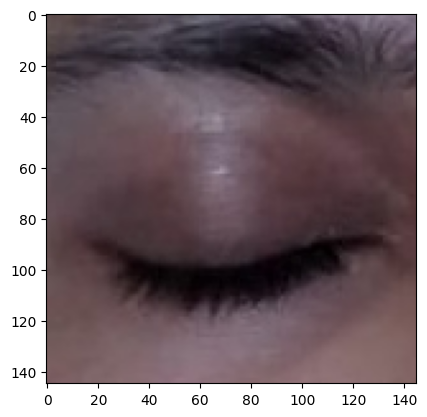

In [4]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"archive\train\Closed\_0.jpg"))

## Image array

In [5]:
a = plt.imread(r"archive\train\yawn\10.jpg")

## Image shape

In [6]:
a.shape

(480, 640, 3)

## Visualize yawn image(Background is unnecessary. We need only face image array) 


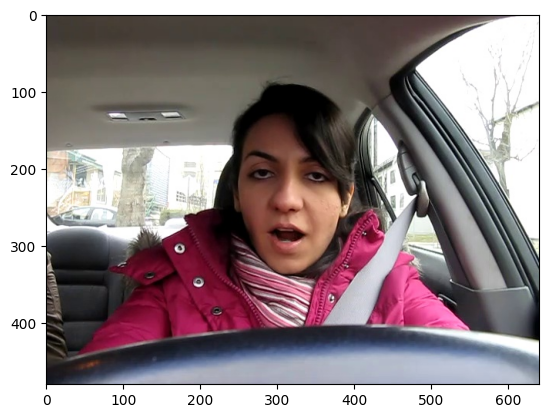

In [7]:
plt.imshow(plt.imread(r"archive\train\yawn\10.jpg"))

## Take only face

In [8]:
def face_for_yawn(direc=r"archive\train", face_cas_path=r"E:/driver_drowsiness_system_CNN-main/driver_drowsiness_system_CNN-main/data/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


## For Closed and Open eye

In [9]:
def get_data(dir_path=r"archive\train", face_cas=r"E:/driver_drowsiness_system_CNN-main/driver_drowsiness_system_CNN-main/data/haarcascade_frontalface_default.xml", eye_cas=r"E:/driver_drowsiness_system_CNN-main/driver_drowsiness_system_CNN-main/data/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [10]:
data_train = get_data()

2
3


## Extend data and Convert array

In [11]:
import cv2
import os
import numpy as np

def append_data():
    yaw_no = face_for_yawn()  # Assuming face_for_yawn is defined elsewhere
    data = get_data()         # Assuming get_data is defined elsewhere
    yaw_no.extend(data)
    
    # Resize image arrays to a common shape and separate into data and labels
    resized_data = []
    labels = []
    for img_array, class_num in yaw_no:
        resized_img = cv2.resize(img_array, (145, 145))  # Resize to a common shape
        resized_data.append(resized_img)
        labels.append(class_num)
    
    # Convert lists to NumPy arrays
    X = np.array(resized_data)
    y = np.array(labels)
    
    return X, y

new_data_X, new_data_y = append_data()


0
1
2
3


## New variable to store

In [12]:
#new_data = append_data()

## Separate label and features

## Reshape the Array

In [14]:
X = np.array(new_data_X)
X = X.reshape(-1, 145, 145, 3)

## LabelBinarizer

In [15]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(new_data_y)

## Label array

In [16]:
y = np.array(y)

## Train Test split

In [17]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [18]:
len(X_test)

578

## Import some dependencies

In [19]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Data Augmentation

In [20]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [21]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

c:\Users\nihal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 143, 143, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 71, 71, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,140 (1.89 MB)

 Trainable params: 495,140 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Train the model
for i in range(1,20):
   history = model.fit(train_generator, epochs=1, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

# Check the evaluation result
if history is None:
    print("Evaluation result is None.")
else:
    # Print the evaluation result
    print("Evaluation result:", history)

    # Check if the evaluation result has items attribute
    if hasattr(history, 'items'):
        # Get the items from the evaluation result
        items = history.items()
        print("Items:", items)
    else:
        print("Evaluation result does not have 'items' attribute.")


43/43 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9019 - loss: 0.2359 - val_accuracy: 0.9170 - val_loss: 0.2179
43/43 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9102 - loss: 0.2237 - val_accuracy: 0.9170 - val_loss: 0.1906
43/43 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9201 - loss: 0.2197 - val_accuracy: 0.9343 - val_loss: 0.1783
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9134 - loss: 0.2352 - val_accuracy: 0.9394 - val_loss: 0.1639
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9239 - loss: 0.2008 - val_accuracy: 0.9394 - val_loss: 0.1552
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8982 - loss: 0.2222 - val_accuracy: 0.9360 - val_loss: 0.1531
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9123 - loss: 0.2112 - val_accuracy: 0.9481 - val_loss: 0.1424
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9392 - loss: 0.1580 - val_accuracy: 0.9170 - val_loss: 0.1987
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9319 - loss: 0.1830 - val_a

## History

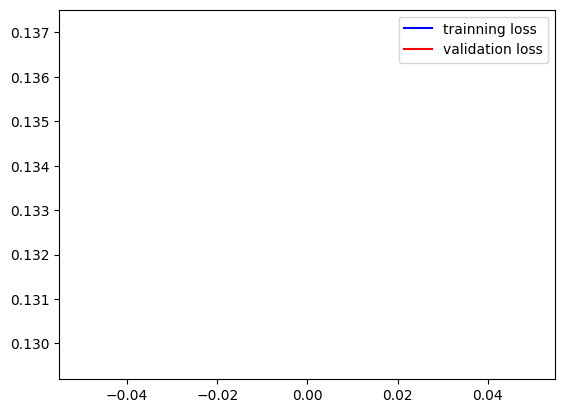

In [40]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## Save Model

In [41]:
model.save("drowiness_new7.h5")

In [42]:
model.save("drowiness_new7.keras")

# Prediction

In [43]:
# Assuming model.predict(X_test) returns the probabilities for each class
y_pred_prob = model.predict(X_test)

# Get the predicted class indices
y_pred_class = np.argmax(y_pred_prob, axis=1)

# Now y_pred_class contains the predicted class labels for each sample in X_test


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 359ms/step


In [44]:
y_pred_prob
y_pred_class

array([3, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 2, 0, 3, 3, 3,
       2, 1, 1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 3, 1, 2, 1, 3, 3, 2, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 1, 3, 1, 3, 2, 0, 3, 2, 2, 2, 2, 1,
       3, 3, 2, 3, 3, 3, 1, 1, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 2, 1, 2, 3,
       1, 1, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 2, 1, 1, 2, 3, 3, 2, 0, 3, 3,
       1, 3, 1, 2, 3, 3, 2, 1, 2, 2, 2, 1, 3, 3, 2, 3, 2, 0, 2, 3, 3, 3,
       3, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 2, 0, 2, 3, 0, 2, 1, 3, 2, 3, 1, 2, 3, 1, 3, 2, 2, 2, 3, 2, 0,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 1, 3,
       1, 3, 2, 3, 3, 3, 3, 0, 1, 2, 1, 0, 3, 3, 1, 3, 3, 1, 3, 3, 0, 1,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 1, 2, 2, 2, 1, 3, 3, 2, 2,
       3, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 1, 1, 0, 3, 3, 3, 3, 2,
       2, 1, 2, 2, 2, 3, 2, 0, 2, 2, 1, 3, 2, 3, 1,

# classification report

In [45]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [46]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), y_pred_class, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.97      0.60      0.75        63
     no_yawn       0.78      0.96      0.86        74
      Closed       0.94      0.99      0.96       215
        Open       0.97      0.95      0.96       226

    accuracy                           0.93       578
   macro avg       0.92      0.88      0.88       578
weighted avg       0.93      0.93      0.92       578



# predicting function

In [47]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145

def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new7.keras")


# Prediction 
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [48]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare(r"archive\train\no_yawn\1067.jpg")])
np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


1

In [49]:
prediction = model.predict([prepare(r"archive\train\Closed\_101.jpg")])
np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2

In [50]:
prediction = model.predict([prepare(r"archive\train\Closed\_104.jpg")])
np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


2